# DBScan Feature Extraction for PEX Pipe

In [8]:
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from os import listdir
from mpl_toolkits.mplot3d import axes3d
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

## Functions

In [9]:
def IR_PCA(input_data, PCs):
    """
    Perform a principle component analysis on a single IR dataset. 
    This function is meant to be used on a dataset containing a single sample.
    It returns the dataframe of the transformed data, the loading dataframe, 
    and the PCA model itself. 
    """
    pca_model = PCA(n_components = PCs)
    data_PCs = pca_model.fit_transform(input_data)
    
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
    PC_df = pd.DataFrame(data = data_PCs, columns = columns_list)
    
    feature_weights = pca_model.components_
    loadings_df = pd.DataFrame(feature_weights)
    
    print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))
    
    return(PC_df, loadings_df, pca_model)

def IR_DBSCAN(input_data, eps, min_samples):
    """TO BE COMPLETED 
    Perform a density based scan on the provided data. 

    Built for doing DBScan on PCA data of the PEX-a pipe spectral changes. 
    """
    # Apply DBSCAN
    db = DBSCAN(eps, min_samples).fit(input_data)

    labels = db.labels_
    # Get number of cores and features, cores should be two for the PEX samples 
    numberOfCores, numberOfFeautures = db.components_

    return(db, labels, numberOfFeautures, numberOfCores)

def trainPCAModel(path, trainingFiles, PCs, modelName):
    """
    Train a principle component model and save it to a pickle file. 

    path: Filepath to the data that will be used to train the PCA model. 
    trainingFiles: Filesname for the data that will be used to train the PCA model. 
    modelName: The filename of the pickle file that will contain the PCA model. 
    """
    input_data = pd.concat([pd.read_csv(path+file) for file in trainingFiles])

    pca_model = PCA(n_components = PCs)
    data_PCs = pca_model.fit_transform(input_data)
    
    columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
    PC_df = pd.DataFrame(data = data_PCs, columns = columns_list)
    
    feature_weights = pca_model.components_
    loadings_df = pd.DataFrame(feature_weights)

    # Save the model to a pickle file
    if modelName.endswith('.pkl'):
        with open(modelName, 'wb') as f:
            pickle.dump(pca_model, f)
            f.close
    else: 
        with open(modelName+'.pkl', 'wb') as f:
            pickle.dump(pca_model, f)
            f.close

    print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))

    return PC_df, loadings_df

def distribution_Selection(df, distributionIdx, numberOfSigmas):
    """
    Screens data based on the distribution of a given column in a pandas dataframe. 
    Built for screening out dataset values that do not have a sufficient 2019 wavenumber 
    integral for the PEX project. Can be modified to projects liking. 

    Returns the selected datas indexes, the discarded indexes, the mask used to select the data,
    the x position of the distribution mode, and the column values of the distribution that is
    being used to screen data. In this case the values of the baseline integral of the PE 2019
    wavenumber peak. 
    """
    
    df[distributionIdx] = df[distributionIdx].astype(float)

    #creating variable for the array of Polyethylene Area
    area = df['1981.7 - 2095.8'].values

    # Use Gaussian KDE to find the center position of the rightmost mode by creating x coords
    # and then using np.argmax to determine the point with the highest number of counts
    kde = gaussian_kde(area)
    xs = np.linspace(area.min(), area.max(), 1000) 
    modePosition = xs[np.argmax(kde(xs))]

    # Use only the values greater than 1.5 to determine the std of the PE peaks
    positive_vals = area[area > 1.5]
    sigma = positive_vals.std()

    lowerDistributionBound = modePosition - numberOfSigmas * sigma
    upperDistributionBound = modePosition + numberOfSigmas * sigma

    # Select the range of PE normalization integral to be accepted by the mask
    mask_selected = (area >= lowerDistributionBound) & (area <= upperDistributionBound)
    selected_indexes = df.index[mask_selected]
    discarded_indexes = df.index[~mask_selected]

    return selected_indexes, discarded_indexes, mask_selected, modePosition, area


## Manage the Dataset

Index([1799.4, 1797.8, 1796.2, 1794.6, 1793.1, 1791.5, 1789.9, 1788.3, 1786.7,
       1785.1,
       ...
        915.5,  913.9,  912.4,  910.8,  909.2,  907.6,  906.0,  904.4,  902.9,
        901.3],
      dtype='object', length=505)
Index([1799.4, 1797.8, 1796.2, 1794.6, 1793.1, 1791.5, 1789.9, 1788.3, 1786.7,
       1785.1,
       ...
        915.5,  913.9,  912.4,  910.8,  909.2,  907.6,  906.0,  904.4,  902.9,
        901.3],
      dtype='object', length=505)
         map_x    map_y Sample Name  1981.7 - 2095.8  1799.4    1797.8  \
0      37985.1  23998.5    0d 820um          3.41326       0  0.000501   
1      37990.5  23998.5    0d 820um          3.49233       0  0.000457   
2      37996.0  23998.5    0d 820um          3.45759       0  0.000876   
3      38001.4  23998.5    0d 820um          3.42111       0  0.000408   
4      38006.8  23998.5    0d 820um          3.34035       0  0.001325   
...        ...      ...         ...              ...     ...       ...   
52219  40172.2

(-1.0, 5.455852222222222)

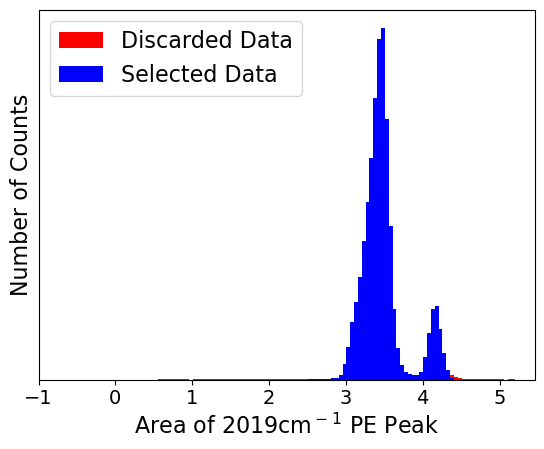

In [10]:
"""
Here we are choosing that dataset that we are going to look at using the PCA model
"""

path ='../data/'
filename = path + 'SMP65#013 28d 920um'
filename += '.csv'

test_df = pd.read_csv(filename)
# Obtain the last Index before starting wavenumbers, this may change depending on data
last_nonwavenum_idx = test_df.columns.get_loc('1981.7 - 2095.8') + 1
# Create an array of strings containing the wavenumbers
test_df = test_df.rename(columns=lambda c: round(float(c), 1) if c not in test_df.columns[:last_nonwavenum_idx] else c)

wavenumbers = test_df.columns[last_nonwavenum_idx:]
print(wavenumbers)

"""
This part is for training PCA on multiple datasets
"""

#List all of the files in the data directory.
allFiles = listdir(path)
# Take only the files that contain data pertaining to SMP65#010 
trainingFiles = [file for file in allFiles if 'SMP65#010' in file and file.endswith('.csv')]

trainingFiles = sorted(trainingFiles, key=lambda x: int(re.search(r'(?<= )(.+?)(?=d)', x).group()))

#print(trainingFiles)

# Read all of the data and place the dataframes into a list
trainingDataframeList = [pd.read_csv(path+file) for file in trainingFiles]

# Lambda function to round all of the wavenumbers so that they are all matching, and then concatenate all the datasets together

rawTrainingDataframe = pd.concat(
    (
        df.rename(
            columns=lambda c: round(float(c), 1) if c not in df.columns[:last_nonwavenum_idx] else c
        )
        for df in trainingDataframeList
    ),
    ignore_index=True
)

#rawTrainingDataframe['aged_time'] = rawTrainingDataframe['Sample Name'].str.strip().str.extract(r'(\d+)').astype(int)

# Sort by the extracted numeric value
#rawTrainingDataframe = rawTrainingDataframe.sort_values('aged_time').drop(columns='aged_time').reset_index()

wavenumbers = rawTrainingDataframe.columns[last_nonwavenum_idx:]
print(wavenumbers)

selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(rawTrainingDataframe, '1981.7 - 2095.8', 3)

print(rawTrainingDataframe)

bin_width = 0.05
bins = np.arange(min(areaPE), max(areaPE) + bin_width, bin_width)

plt.hist(areaPE,bins=bins, color='r')
plt.hist(areaPE[mask_selected], bins=bins, color='b')
plt.yticks([])
plt.xticks(fontsize=14)
plt.ylabel('Number of Counts', fontsize=16)
plt.xlabel(f'Area of 2019cm$^-$$^1$ PE Peak', fontsize=16)
plt.legend(['Discarded Data', 'Selected Data'], fontsize=16, loc='upper left')
plt.xlim([-1, modePosition + 2])

# Perform the PCA Analysis and Plot Loading Spectra

Explained variation per principal component: [0.45364558 0.29447328 0.12910778]
Raw Dataset shape:  (52224, 505) Filtered Dataset shape:  (51771, 505)


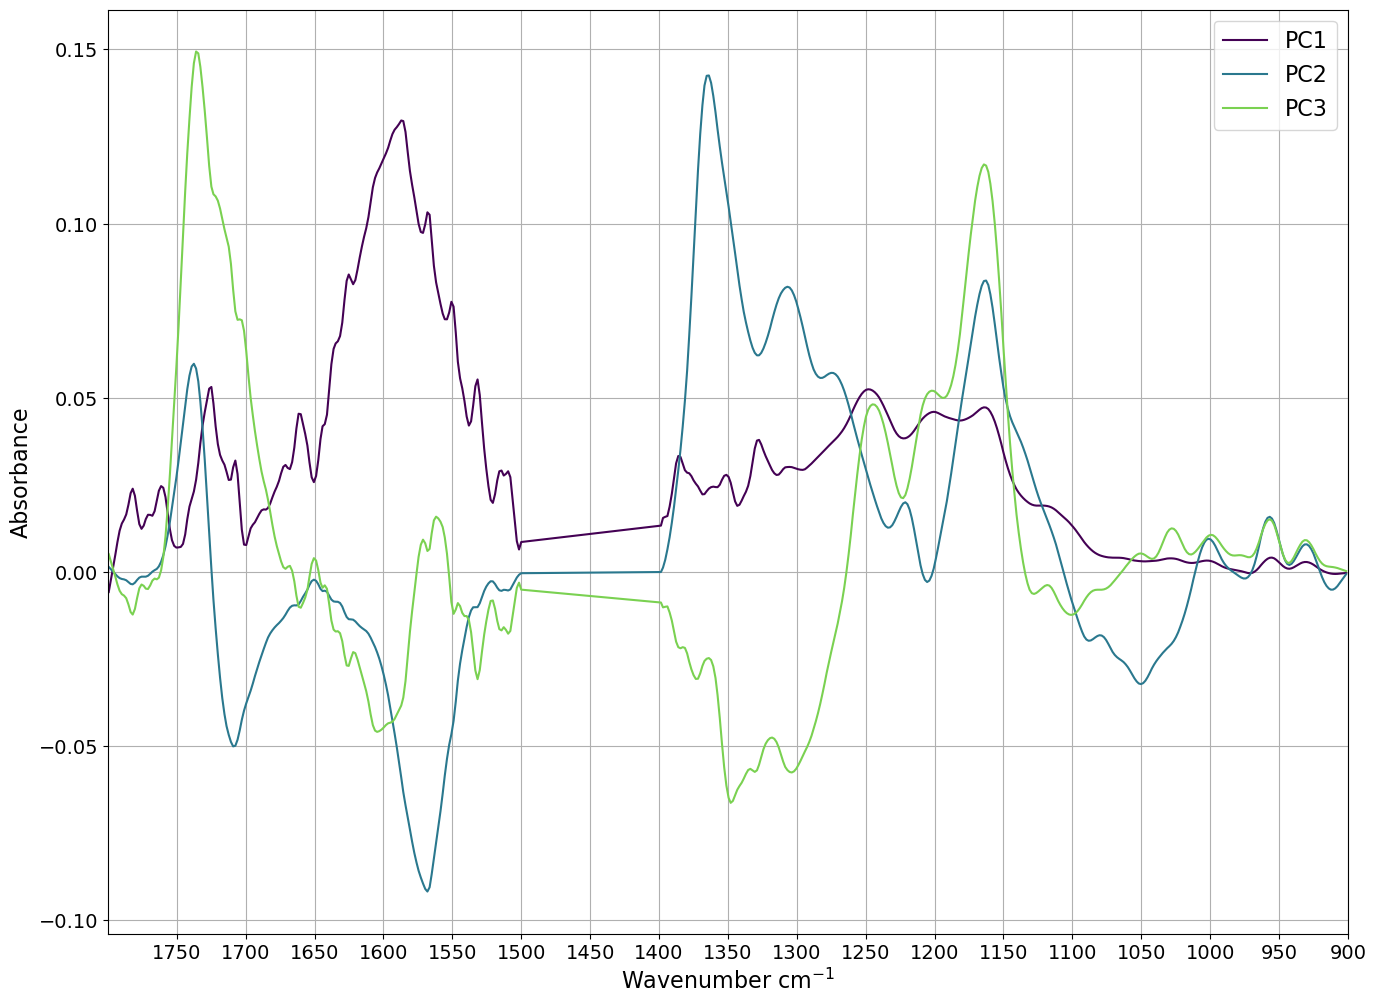

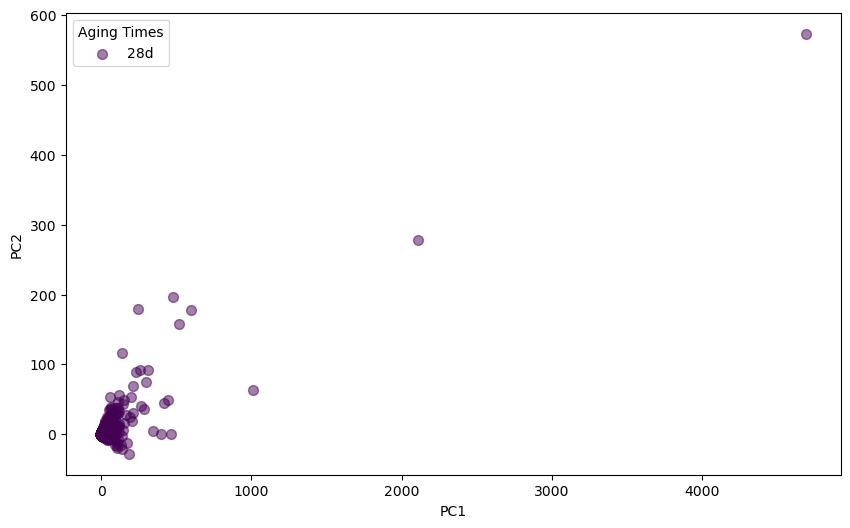

<Figure size 640x480 with 0 Axes>

In [11]:
PCs = 3
# Create dataset containing ONLY the wavenumbers
rawData = rawTrainingDataframe[wavenumbers].copy()

# Modify created dataset to contain ONLY the masked values
Masked_PC_inputData = rawData[mask_selected].values

# Train a PCA model on the masked values values
PCA_df_init, loadings_df_init, pca_model = IR_PCA(Masked_PC_inputData, PCs=PCs)

print("Raw Dataset shape: ", rawData.shape, "Filtered Dataset shape: ", Masked_PC_inputData.shape)

# Save the model to a pickle file
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca_model, f)
# Open the same model
with open('pca_model.pkl', 'rb') as f:
    loaded_pca_model = pickle.load(f)


selected_indexes, discarded_indexes, mask_selected, modePosition, areaPE = distribution_Selection(test_df, '1981.7 - 2095.8', 3)

rawTestData = test_df[wavenumbers].copy()


Masked_PC_inputData = test_df[mask_selected].values

# Use the model again on the unmasked values to get the same result for the complete dataset
data_PCs = loaded_pca_model.transform(rawTestData.values)
columns_list = ['PC'+ str(x) for x in range(1, PCs+1)]
PCA_df = pd.DataFrame(data = data_PCs, columns = columns_list)

PCA_df['map_x'] = test_df['map_x'].reindex
PCA_df['map_y'] = test_df['map_y'].reindex
PCA_df['Aging Times'] = test_df['Sample Name']

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, PCs))

plt.figure(figsize=(16,12))
plt.xlabel('Wavenumber cm$^{-1}$', fontsize=16)
plt.ylabel('Absorbance', fontsize=16)
plt.xticks(np.arange(900, 1800, step=50), fontsize=14)
plt.yticks(fontsize=14)
for i in range(PCs):
    loadings = savgol_filter(loadings_df_init.iloc[i, :].values, 9, 1)
    plt.plot(
        wavenumbers,
        loadings,
        color=colors[i],
        label=f"PC{i+1}"
    )

legend_labels = [f'PC{i+1}' for i in range(PCs)]
plt.legend(legend_labels, fontsize=16, loc='upper right')
#plt.xlim(wavenumbers[0], wavenumbers[-1])
plt.grid()
plt.xlim(1800, 900)
plt.savefig("PCs_loading_spectrum.png", dpi=900)

"""
Plot two PCs against each other and color by aging time to see how they vary
"""
colour_list=[]
plt.figure(figsize=(10,6))
unique_samples = PCA_df['Aging Times'].unique()
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(unique_samples)))
i=0
for sample in unique_samples:
    subset = PCA_df[PCA_df['Aging Times'] == sample]
    plt.scatter(subset['PC1'].values, subset['PC2'].values,
                alpha=0.5,
                s=50,
                label=sample.split(" ")[0], color=colors[i])
    i+=1
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Aging Times')
plt.show()
plt.savefig("PCs_plot.jpeg", dpi=900)

"""
Plot three PCs in a meshgrid and color by aging time
"""
if False: 
    PC1 = PCA_df['PC1'].to_numpy() 
    PC2 = PCA_df['PC2'].to_numpy()
    PC3 = PCA_df['PC3'].to_numpy()

    X, Y, Z = np.meshgrid(PC1[::100], PC2[::100], PC3[::100])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, cmap='viridis')
    plt.show()


# Plotting the PCA Spatial Analysis

Preparing data for plottings

In [12]:
PC1 = PCA_df['PC1'].to_numpy()
PC2 = PCA_df['PC2'].to_numpy()
PC3 = PCA_df['PC3'].to_numpy()

#Reposition the mapping to start at 0,0 
Map_x = test_df['map_x'].to_numpy()
Map_y = test_df['map_y'].to_numpy()
Map_y2 = []
Map_x2 = []
Min_x = min(Map_x)
Min_y = min(Map_y)

Map_x2 = Map_x - Min_x
Map_y2 = Map_y - Min_y

x_adjusted=(np.unique(Map_x2)).tolist()
y_adjusted=(np.unique(Map_y2)).tolist()

X,Y = np.meshgrid(x_adjusted, y_adjusted)

Xsize, Ysize = len(x_adjusted), len(y_adjusted)
print("Length of X, Y: ", Xsize, Ysize, "\n")

print("Length of X*Y: ",len(x_adjusted)*len(y_adjusted), "\n")

print("Lenght of PC1: ", len(PC1), "Legnth of PC2: ", len(PC2), "\n")
# Format PC1 for plotting
PC1resized = np.reshape(PC1, (Ysize, Xsize))

# Format PC2 for plotting
PC2resized = np.reshape(PC2, (Ysize,Xsize))

# Format PC2 for plotting
PC3resized = np.reshape(PC3, (Ysize,Xsize))




Length of X, Y:  384 128 

Length of X*Y:  49152 

Lenght of PC1:  49152 Legnth of PC2:  49152 



Creating Figures and Plotting the PCs

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

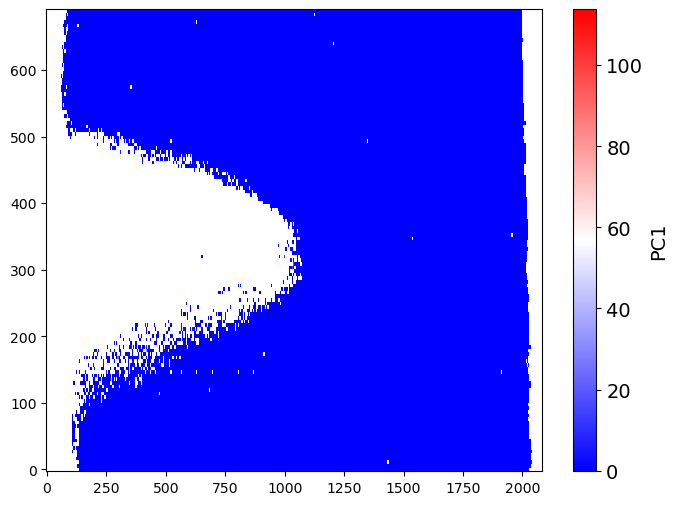

In [ ]:
# Prepare colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 0.8, len(loadings_df_init)))
cmap.set_bad(color='0.7')  # dull grey for masked values

# Setting up the mask for plotting
PC1_masked =  np.ma.array(PC1resized, mask=~mask_selected)
PC2_masked =  np.ma.array(PC2resized, mask=~mask_selected)
PC3_masked =  np.ma.array(PC3resized, mask=~mask_selected)

"""
Plotting the first Principal Component
"""

fig1, ax1 = plt.subplots(figsize=(8, 6))

im1 = ax1.pcolormesh(X, Y, PC1_masked, cmap='bwr', shading='auto', vmin=min(PC1_masked), vmax=max(PC1_masked))

cbar = fig1.colorbar(im1, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC1', fontsize=14)

ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])

"""
Plotting the second Principal Component 
"""

fig2, ax2 = plt.subplots(figsize=(8, 6))

im2 = ax2.pcolormesh(X, Y, PC2_masked, cmap='bwr', shading='auto', vmin=min(PC2_masked), vmax=max(PC2_masked))

cbar = fig2.colorbar(im2, ax=ax2)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'PC2', fontsize=14)

ax2.set_aspect('equal')

ax2.set_xticks([])
ax2.set_yticks([])

if PCs > 2:
    fig3, ax3 = plt.subplots(figsize=(8, 6))

    im3 = ax3.pcolormesh(X, Y, PC3_masked, cmap='bwr', shading='auto', vmin=min(PC3_masked), vmax=max(PC3_masked))

    cbar = fig3.colorbar(im3, ax=ax3)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(r'PC3', fontsize=14)

    ax3.set_aspect('equal')

    ax3.set_xticks([])
    ax3.set_yticks([])


## Density Based Scan for Different 